<a href="https://colab.research.google.com/github/eunwoo63/-/blob/main/Internet_usage%2Cfitness%EC%A0%84%EC%B2%98%EB%A6%AC_%EC%A0%95%EC%9D%80%EC%9A%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 데이터불러오기, 패키지 로드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import warnings

In [3]:
warnings.filterwarnings('ignore', category=FutureWarning)

sns.set(style="whitegrid")
%matplotlib inline

In [4]:
train = pd.read_csv('/content/drive/MyDrive/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/content/drive/MyDrive/child-mind-institute-problematic-internet-use/test.csv')
data_dict = pd.read_csv('/content/drive/MyDrive/child-mind-institute-problematic-internet-use/data_dictionary.csv')

In [5]:
def calculate_stats(data, columns):
    if isinstance(columns, str):
        columns = [columns]

    stats = []
    for col in columns:
        if data[col].dtype in ['object', 'category']:
            counts = data[col].value_counts(dropna=False, sort=False)
            percents = data[col].value_counts(normalize=True, dropna=False, sort=False) * 100
            formatted = counts.astype(str) + ' (' + percents.round(2).astype(str) + '%)'
            stats_col = pd.DataFrame({'count (%)': formatted})
            stats.append(stats_col)
        else:
            stats_col = data[col].describe().to_frame().transpose()
            stats_col['missing'] = data[col].isnull().sum()
            stats_col.index.name = col
            stats.append(stats_col)

    return pd.concat(stats, axis=0)

In [6]:
train['Age Group'] = pd.cut(
    train['Basic_Demos-Age'],
    bins=[4, 12, 18, 22],
    labels=['Children (5-12)', 'Adolescents (13-18)', 'Adults (19-22)']
)
calculate_stats(train, 'Age Group')

,count (%)
Age Group,
Children (5-12),2919 (73.71%)
Adolescents (13-18),953 (24.07%)
Adults (19-22),88 (2.22%)


# fitness Gram Vitals and Treadmill 데이터 처리

측정수단 - 칼럼명 - 설명

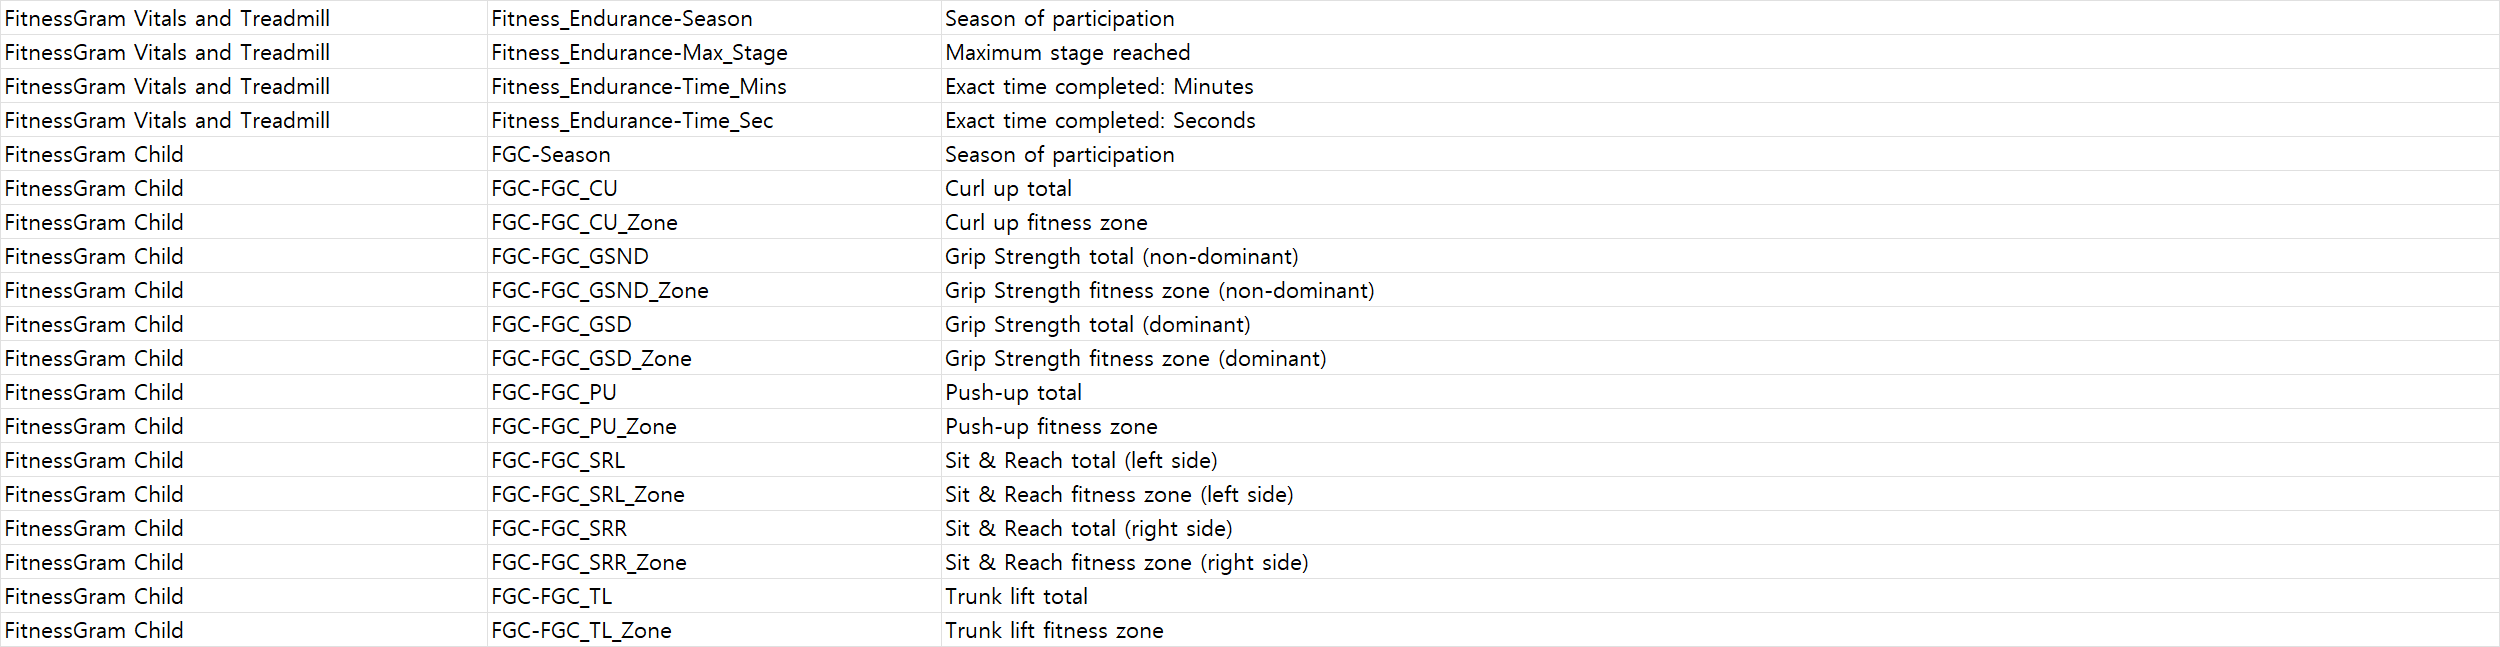

In [7]:
'''
Dictionary를 이용하여 데이터를 instrument기준으로 그룹화
EDA를 편하게 하기 위한 용도
'''

groups = data_dict.groupby('Instrument')['Field'].apply(list).to_dict()


In [8]:
# FitnessGram 열 이름 확인
groups.get('FitnessGram Vitals and Treadmill', [])

['Fitness_Endurance-Season',
 'Fitness_Endurance-Max_Stage',
 'Fitness_Endurance-Time_Mins',
 'Fitness_Endurance-Time_Sec']

In [9]:
'''
요약통계량 확인
'''

cols = [
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec'
]
calculate_stats(train, cols)

,count,mean,std,min,25%,50%,75%,max,missing
Fitness_Endurance-Max_Stage,743.0,4.989233,2.014072,0.0,4.00,5.0,6.0,28.0,3217
Fitness_Endurance-Time_Mins,740.0,7.370270,3.189662,0.0,6.00,7.0,9.0,20.0,3220
Fitness_Endurance-Time_Sec,740.0,27.581081,17.707751,0.0,12.75,28.0,43.0,59.0,3220


In [15]:
'''
	calculate_stats_FitnessGram <데이터프레임>
	fitnessgram 요약통계량을 변수로 저장
  결측치 비율을 시각화하기 위해 생성
'''
calculate_stats_FitnessGram = calculate_stats(train, cols)
1- calculate_stats_FitnessGram['count']/(calculate_stats_FitnessGram['missing']+calculate_stats_FitnessGram['count'])


,0
Fitness_Endurance-Max_Stage,0.812374
Fitness_Endurance-Time_Mins,0.813131
Fitness_Endurance-Time_Sec,0.813131


결측치 비율이 81%로 삭제하는 것이 좋을듯하네요
or 분포가 균일한 편이므로 평균값으로 대체해보는 방법정도를 사용해도 좋을듯합니다.

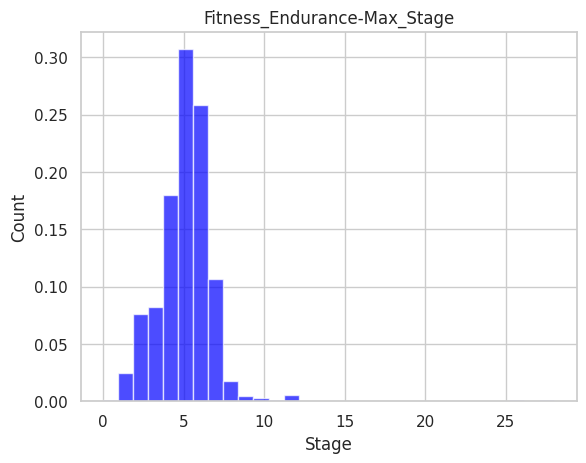

In [16]:
'''
히스토그램으로 분포확인
'''
plt.hist(train['Fitness_Endurance-Max_Stage'], bins=30, alpha=0.7, color='blue', density=True)
plt.title("Fitness_Endurance-Max_Stage")
plt.xlabel("Stage")
plt.ylabel("Count")
plt.show()

이상치제거

In [17]:
'''
일반적으로 사용되는 4분위수의 1.5IQR만큼을 이상치로 잡고 제거하였습니다.
'''
'''
# Fitness_Endurance-Max_Stage열에 대한 이상치 탐지 및 상한값 초과 데이터 제거
train_fitness_outlier_remove = train.copy()

for col in ['Fitness_Endurance-Max_Stage']:
    Q1 = train_fitness_outlier[col].quantile(0.25)
    Q3 = train_fitness_outlier[col].quantile(0.75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR
    # 상한값 초과 데이터만 제거
    train_fitness_outlier = train_fitness_outlier[train_fitness_outlier[col] <= upper_bound]
'''

"\n# Fitness_Endurance-Max_Stage열에 대한 이상치 탐지 및 상한값 초과 데이터 제거\ntrain_fitness_outlier_remove = train.copy()\n\nfor col in ['Fitness_Endurance-Max_Stage']:\n    Q1 = train_fitness_outlier[col].quantile(0.25)\n    Q3 = train_fitness_outlier[col].quantile(0.75)\n    IQR = Q3 - Q1\n    upper_bound = Q3 + 1.5 * IQR\n    # 상한값 초과 데이터만 제거\n    train_fitness_outlier = train_fitness_outlier[train_fitness_outlier[col] <= upper_bound]\n"

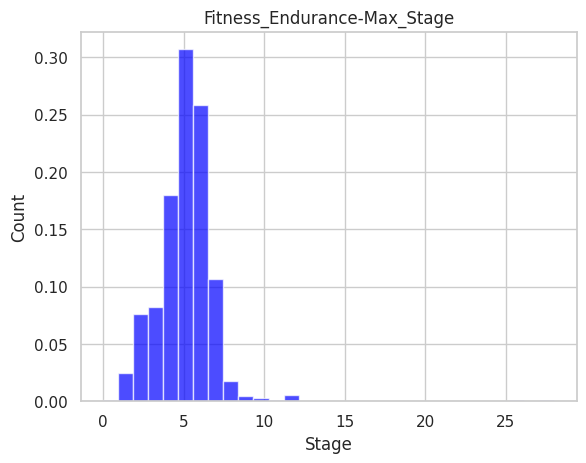

In [20]:
'''
히스토그램으로 분포확인
'''
plt.hist(train['Fitness_Endurance-Max_Stage'], bins=30, alpha=0.7, color='blue', density=True)
plt.title("Fitness_Endurance-Max_Stage")
plt.xlabel("Stage")
plt.ylabel("Count")
plt.show()

In [21]:
# 평균값 확인 후 대체
train_fitness_replacement = train.copy()
train_fitness_replacement['Fitness_Endurance-Max_Stage'] = train_fitness_replacement['Fitness_Endurance-Max_Stage'].replace(0, np.nan).fillna(train_fitness_replacement['Fitness_Endurance-Max_Stage'].mean())

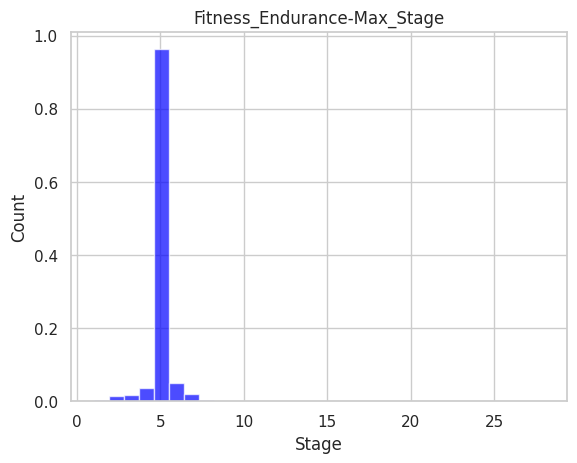

In [22]:
plt.hist(train_fitness_replacement['Fitness_Endurance-Max_Stage'], bins=30, alpha=0.7, color='blue', density=True)
plt.title("Fitness_Endurance-Max_Stage")
plt.xlabel("Stage")
plt.ylabel("Count")
plt.show()

# FitnessGram Child 데이터처리

In [23]:
data_dict[data_dict['Instrument'] == 'FitnessGram Child']

,Instrument,Field,Description,Type,Values,Value Labels
18,FitnessGram Child,FGC-Season,Season of participation,str,"Spring, Summer, Fall, Winter",NaN
19,FitnessGram Child,FGC-FGC_CU,Curl up total,int,NaN,NaN
20,FitnessGram Child,FGC-FGC_CU_Zone,Curl up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
21,FitnessGram Child,FGC-FGC_GSND,Grip Strength total (non-dominant),float,NaN,NaN
22,FitnessGram Child,FGC-FGC_GSND_Zone,Grip Strength fitness zone (non-dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
23,FitnessGram Child,FGC-FGC_GSD,Grip Strength total (dominant),float,NaN,NaN
24,FitnessGram Child,FGC-FGC_GSD_Zone,Grip Strength fitness zone (dominant),categorical int,"1,2,3","1=Weak, 2=Normal, 3=Strong"
25,FitnessGram Child,FGC-FGC_PU,Push-up total,int,NaN,NaN
26,FitnessGram Child,FGC-FGC_PU_Zone,Push-up fitness zone,categorical int,"0,1","0=Needs Improvement, 1=Healthy Fitness Zone"
27,FitnessGram Child,FGC-FGC_SRL,Sit & Reach total (left side),float,NaN,NaN


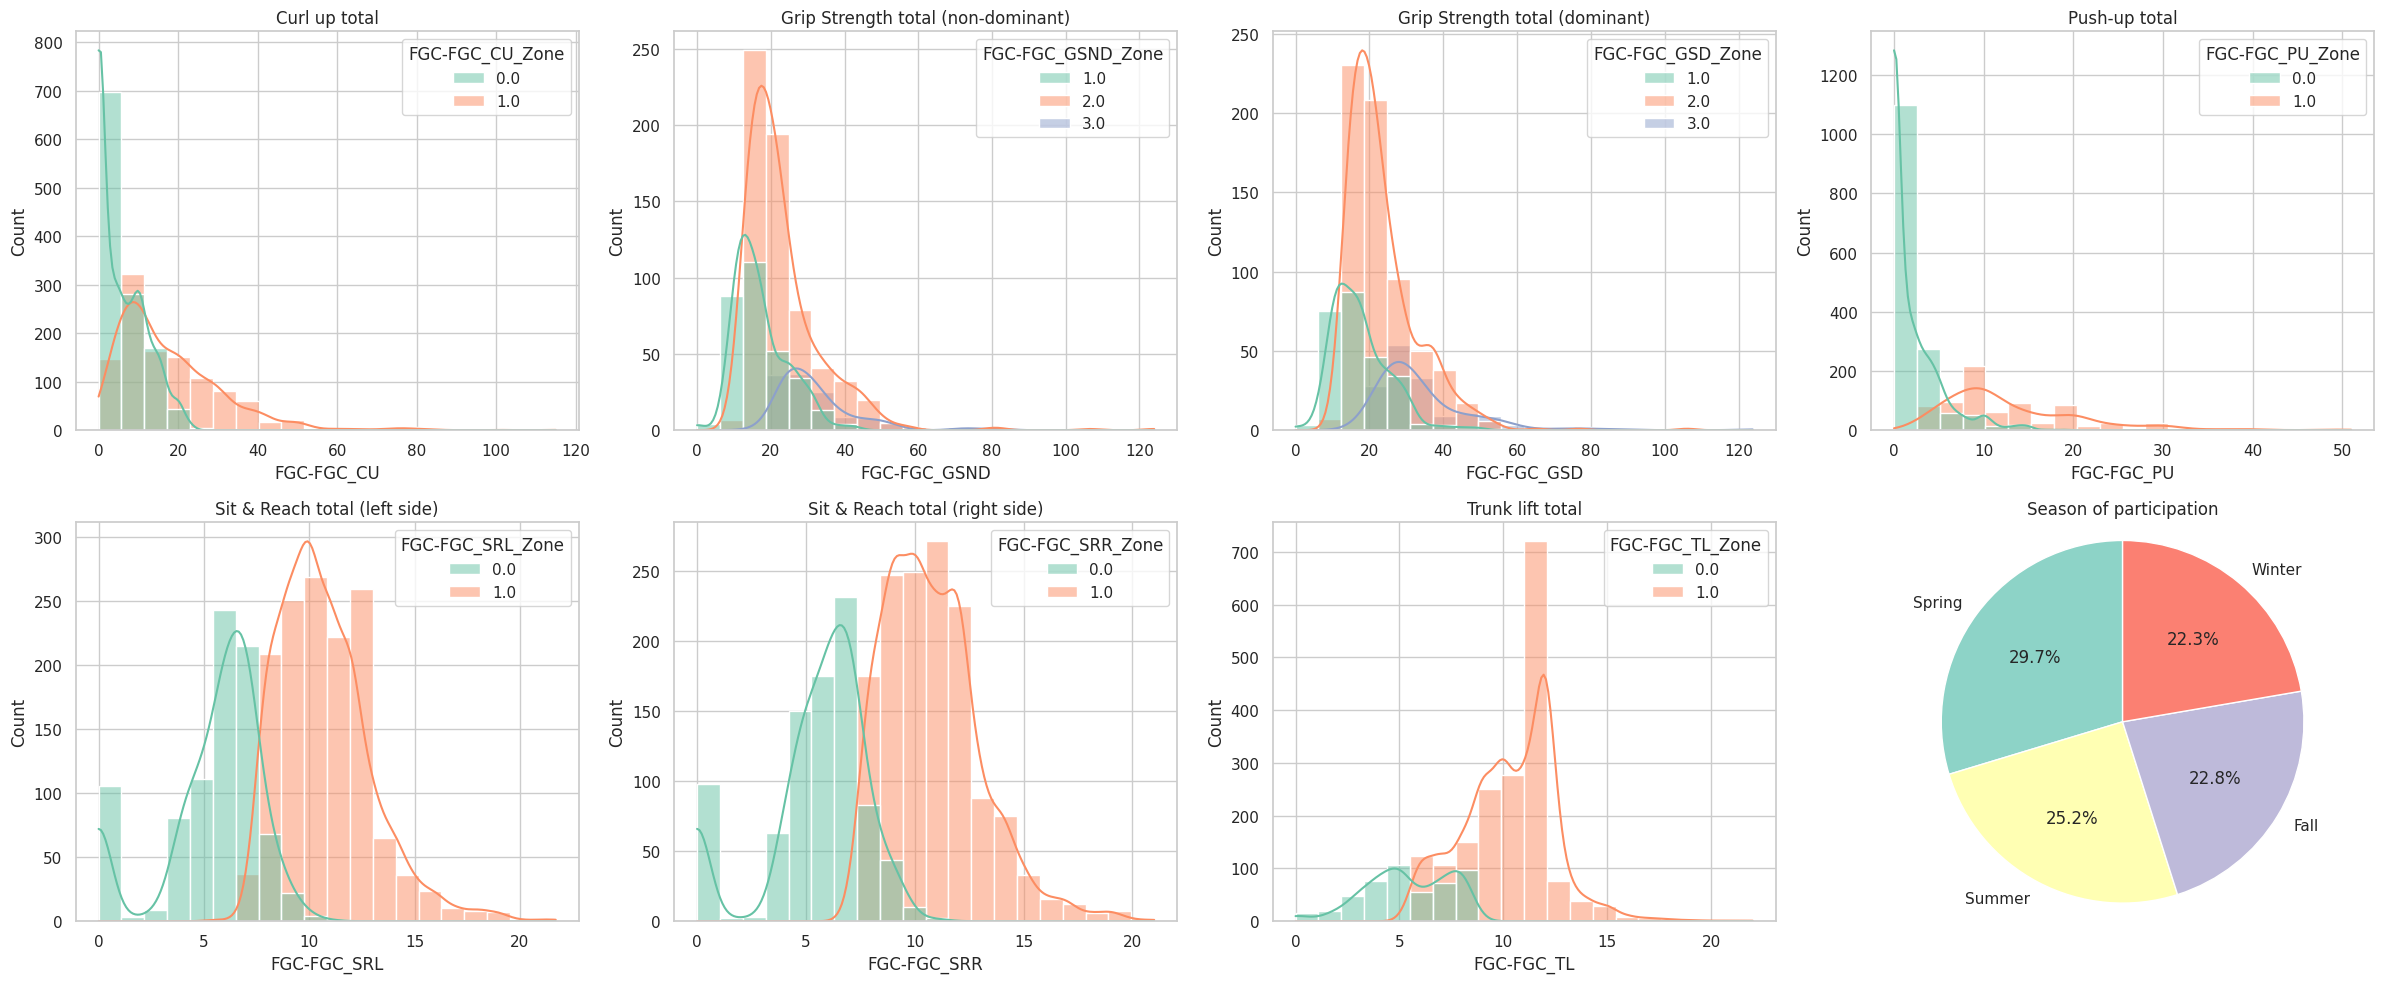

In [24]:
'''
FitnessGram Child 데이터 시각화
'''
fgc_data_dict = data_dict[data_dict['Instrument'] == 'FitnessGram Child']

fgc_columns = []

for index, row in fgc_data_dict.iterrows():
    if '_Zone' not in row['Field']:
        measure_field = row['Field']
        measure_desc = row['Description']

        zone_field = measure_field + '_Zone'
        zone_row = fgc_data_dict[fgc_data_dict['Field'] == zone_field]

        if not zone_row.empty:
            zone_desc = zone_row['Description'].values[0]
            fgc_columns.append((measure_field, zone_field, measure_desc, zone_desc))

fig, axes = plt.subplots(2, 4, figsize=(24, 10))

for idx, (measure, zone, measure_desc, zone_desc) in enumerate(fgc_columns):
    row = idx // 4
    col = idx % 4

    sns.histplot(
        data=train, x=measure,
        hue=zone, bins=20, palette='Set2',
        ax=axes[row, col], kde=True
    )
    axes[row, col].set_title(f'{measure_desc}')

season_counts = train['FGC-Season'].value_counts(normalize=True)
axes[1, 3].pie(
    season_counts, labels=season_counts.index,
    autopct='%1.1f%%', startangle=90,
    colors=sns.color_palette("Set3")
)
axes[1, 3].set_title('Season of participation')
axes[1, 3].axis('equal')

plt.tight_layout()
plt.show()

In [25]:
'''
요약통계량 확인
'''
measurement_columns = [measure for measure, _, _, _ in fgc_columns]
calculate_stats(train, measurement_columns)

,count,mean,std,min,25%,50%,75%,max,missing
FGC-FGC_CU,2322.0,11.259690,11.807781,0.0,3.0,9.00,15.750,115.0,1638
FGC-FGC_GSND,1074.0,22.420438,10.833995,0.0,15.1,20.05,26.600,124.0,2886
FGC-FGC_GSD,1074.0,23.518622,11.148951,0.0,16.2,21.20,28.175,123.8,2886
FGC-FGC_PU,2310.0,5.579654,7.390161,0.0,0.0,3.00,9.000,51.0,1650
FGC-FGC_SRL,2305.0,8.694924,3.429301,0.0,7.0,9.00,11.000,21.7,1655
FGC-FGC_SRR,2307.0,8.805635,3.422167,0.0,7.0,9.00,11.000,21.0,1653
FGC-FGC_TL,2324.0,9.252775,2.988863,0.0,7.0,10.00,12.000,22.0,1636


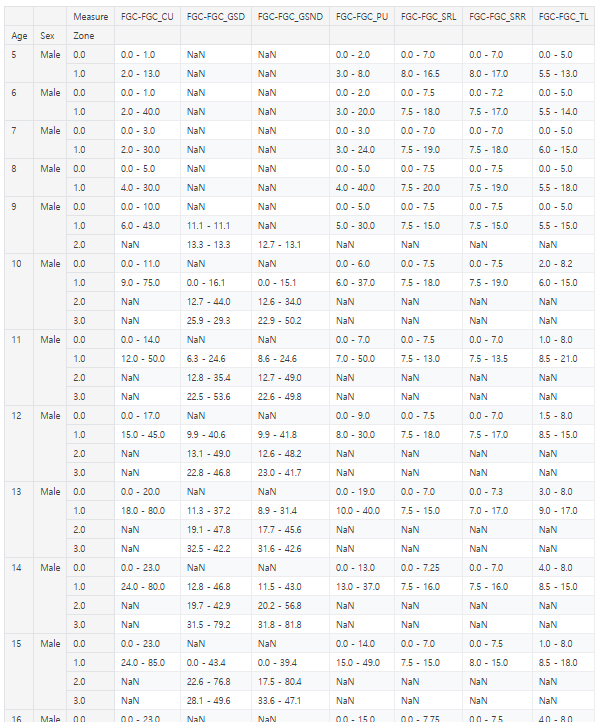

변수별 특징 도출 및 처리방법
1. FGC-FGC_CU
curl-up ( 윗몸일으키기 ) 데이터. 최대값이 지나치게 큼. 1.5IQR 밖의 값 삭제
2. FGC-FGC_GSD & FGC-FGC_GSDN
Grip Strength total ( 주사용손의  악력 ) 데이터. 최대값이 지나치게 큼. 1.5IQR 밖의 값 삭제
3. FGC-FGC_PU  push-up ( 팔굽혀펴기 ) 데이터. 분포가 적당해보이고 상위값도 이상하지않음. 결측치들을 중위값으로 대체
4. FGC-FGC_SRL & FGC-FGC_SRR
Sit & Reach total ( 유연성테스트 ) 데이터. 분포가 적당함. 결측치들을 중위값으로 대체
5. FGC-FGC_TL
Trunk-lift ( 허리유연성테스트 ) 데이터. 이상치가 없어보이나 정규성이 의심되어 중위값대체가 악영향을 미칠듯

ZONE 데이터는 0=Needs Improvement, 1=Healthy Fitness Zone 처럼 fitness 측정치를 토대로 점수를 매긴 것인데, 이것이 명확하지 않음. 그렇기에 측정치만 사용하는 것이 바람직해 보임.

In [26]:
'''
train_fitness_outlier_remove는 전처리를 위한 복사본
FGC-FGC_CU,FGC-FGC_GSD 에 대한 이상치 제거를 함수를 만들어 실행
'''

train_fitness_outlier_remove = train.copy()

def remove_outliers_by_iqr(df, column_name):
    """
    주어진 데이터프레임의 지정된 열에 대해 1.5 IQR을 사용해 상한값을 초과하는 이상치를 NaN으로 대체합니다.

    Parameters:
    df (pd.DataFrame): 이상치를 제거할 데이터프레임
    column_name (str): 이상치를 제거할 열 이름

    Returns:
    pd.DataFrame: 이상치가 제거된 새로운 데이터프레임
    """
    # 1사분위수 (Q1), 3사분위수 (Q3), IQR 계산
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # 상한값 (Upper bound) 계산
    upper_bound = Q3 + 1.5 * IQR

    # 상한값을 초과하는 값을 NaN으로 대체
    df[column_name] = df[column_name].apply(lambda x: np.nan if x > upper_bound else x)

    return df

remove_outliers_by_iqr(train_fitness_outlier_remove,'FGC-FGC_CU')
remove_outliers_by_iqr(train_fitness_outlier_remove,'FGC-FGC_GSD')
remove_outliers_by_iqr(train_fitness_outlier_remove,'FGC-FGC_GSND')

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,Children (5-12)
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,Children (5-12)
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,Children (5-12)
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0,Children (5-12)
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adolescents (13-18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0,Adolescents (13-18)
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN,Children (5-12)
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0,Children (5-12)
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0,Adolescents (13-18)


In [27]:
'''
결측치 중위값으로 대체
FGC-FGC_PU
FGC-FGC_SRL
에서 사용.
'''

def replace_nan_with_median(df, column_name):
    # 해당 열의 중위값 계산
    median_value = df[column_name].median()

    # NaN 값만 중위값으로 대체하고, 0은 그대로 두기
    df[column_name] = df[column_name].apply(lambda x: median_value if pd.isna(x) else x)

    return df

replace_nan_with_median(train_fitness_outlier_remove,'FGC-FGC_PU')
replace_nan_with_median(train_fitness_outlier_remove,'FGC-FGC_SRL')
replace_nan_with_median(train_fitness_outlier_remove,'FGC-FGC_SRR')

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii,Age Group
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0,Children (5-12)
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0,Children (5-12)
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0,Children (5-12)
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0,Children (5-12)
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adolescents (13-18)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0,Adolescents (13-18)
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN,Children (5-12)
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0,Children (5-12)
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0,Adolescents (13-18)


In [28]:
'''
데이터 다시확인
'''
calculate_stats(train_fitness_outlier_remove, measurement_columns)

,count,mean,std,min,25%,50%,75%,max,missing
FGC-FGC_CU,2206.0,9.427924,8.317946,0.0,2.0,8.00,15.0,34.0,1754
FGC-FGC_GSND,1028.0,20.985554,7.909951,0.0,14.9,19.40,25.6,43.6,2932
FGC-FGC_GSD,1028.0,22.029864,8.187207,0.0,15.9,20.75,26.8,46.1,2932
FGC-FGC_PU,3960.0,4.504798,5.785374,0.0,2.0,3.00,4.0,51.0,0
FGC-FGC_SRL,3960.0,8.822424,2.620423,0.0,8.0,9.00,9.5,21.7,0
FGC-FGC_SRR,3960.0,8.886768,2.613548,0.0,8.0,9.00,9.5,21.0,0
FGC-FGC_TL,2324.0,9.252775,2.988863,0.0,7.0,10.00,12.0,22.0,1636


# Internet Usage

In [29]:
'''
PreInt_EduHx-computerinternet_hoursday 인터넷 사용량에 대한 데이터.
0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day 로 제공됨.
'''

train['PreInt_EduHx-computerinternet_hoursday'].unique()

array([ 3.,  0.,  2., nan,  1.])

In [30]:
'''
범주형데이터로 변환
'''

param_map = {0: '< 1h/day', 1: '~ 1h/day', 2: '~ 2hs/day', 3: '> 3hs/day'}
train['internet_use_encoded'] = train[
    'PreInt_EduHx-computerinternet_hoursday'
].map(param_map).fillna('Missing')

param_ord = ['Missing', '< 1h/day', '~ 1h/day', '~ 2hs/day', '> 3hs/day']
train['internet_use_encoded'] = pd.Categorical(
    train['internet_use_encoded'], categories=param_ord,
    ordered=True
)

In [31]:
'''
요약통계량확인
범주형데이터이므로, 이상치를 다룰 것은 없고 결측치 659개에 대한 처리법 고민필요.
'''

calculate_stats(train, 'PreInt_EduHx-computerinternet_hoursday')

,count,mean,std,min,25%,50%,75%,max,missing
PreInt_EduHx-computerinternet_hoursday,,,,,,,,,
PreInt_EduHx-computerinternet_hoursday,3301.0,1.060588,1.094875,0.0,0.0,1.0,2.0,3.0,659


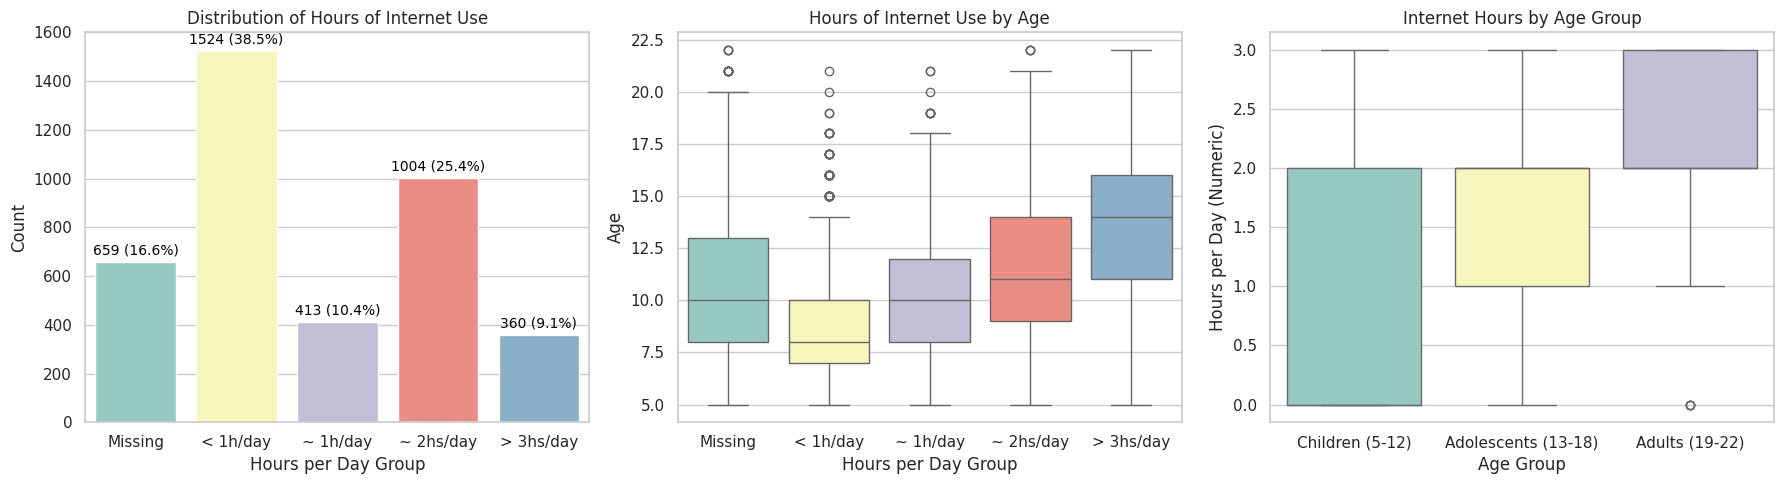

In [32]:
'''
internet use를 다양하게 시각화
'''

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Hours of Internet Use
ax1 = sns.countplot(x='internet_use_encoded', data=train, palette="Set3", ax=axes[0])
axes[0].set_title('Distribution of Hours of Internet Use')
axes[0].set_xlabel('Hours per Day Group')
axes[0].set_ylabel('Count')

total = len(train['internet_use_encoded'])
for p in ax1.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    ax1.annotate(f'{count} ({percentage})', (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5),
                 textcoords='offset points')

# Hours of Internet Use by Age
sns.boxplot(y=train['Basic_Demos-Age'], x=train['internet_use_encoded'], ax=axes[1], palette="Set3")
axes[1].set_title('Hours of Internet Use by Age')
axes[1].set_ylabel('Age')
axes[1].set_xlabel('Hours per Day Group')

# Hours of Internet Use (numeric) by Age Group
sns.boxplot(y='PreInt_EduHx-computerinternet_hoursday', x='Age Group', data=train, ax=axes[2], palette="Set3")
axes[2].set_title('Internet Hours by Age Group')
axes[2].set_ylabel('Hours per Day (Numeric)')
axes[2].set_xlabel('Age Group')

plt.tight_layout()
plt.show()

인터넷 사용시간이 나이와 상관관계가 있는 것으로 보이는데, 연령대(agegroup)별로 인터넷사용시간의 평균값으로 결측치를 대체하는 것이 어떨까.


In [33]:
''''
train_internetuse_replacing은 결측치 대체를 위한 복사본
연령대별로 인터넷사용시간의 평균을 구한 뒤, 결측치를 대체
'''

train_internetuse_replacing = train.copy()
# 연령대별로 PreInt_EduHx-computerinternet_hoursday의 평균을 계산
age_group_means = train.groupby('Age Group')['PreInt_EduHx-computerinternet_hoursday'].mean()

# NaN 값을 연령대별 평균으로 대체
train_internetuse_replacing['PreInt_EduHx-computerinternet_hoursday'] = train_internetuse_replacing.apply(
    lambda row: age_group_means[row['Age Group']] if pd.isna(row['PreInt_EduHx-computerinternet_hoursday']) else row['PreInt_EduHx-computerinternet_hoursday'],
    axis=1
)

In [34]:
calculate_stats(train_internetuse_replacing, 'PreInt_EduHx-computerinternet_hoursday')

,count,mean,std,min,25%,50%,75%,max,missing
PreInt_EduHx-computerinternet_hoursday,,,,,,,,,
PreInt_EduHx-computerinternet_hoursday,3960.0,1.070024,1.018245,0.0,0.0,0.810976,2.0,3.0,0
